# Simulation of production line with defects - Dataset creation and Inference

_This notebook is originally created by [@paularamos](https://github.com/paularamo) for CVPR-2022 Tutorial [How to get quick and performant model for your edge application. From data to application](https://paularamo.github.io/cvpr-2022/)_

### Definitions

[Anomalib](https://github.com/openvinotoolkit/anomalib): Anomalib is a deep learning library that aims to collect state-of-the-art anomaly detection algorithms for benchmarking on both public and private datasets. Anomalib provides several ready-to-use implementations of anomaly detection algorithms described in the recent literature, as well as a set of tools that facilitate the development and implementation of custom models. The library has a strong focus on image-based anomaly detection, where the goal of the algorithm is to identify anomalous images, or anomalous pixel regions within images in a dataset.

[Dobot](https://en.dobot.cn/products/education/magician.html) The Magician is an education robot arm portable and capable to run various automation tasks. With an interface in C++ and python we can control the robot using this notebook. 

> NOTE: 
If you don't have the robot you can replace it by your custome problem. 

### Use case

Using the [Dobot Magician](https://www.dobot.cc/dobot-magician/product-overview.html) we could simulate a production line system. Imagine we have a cubes factory and they need to know when a defect piece appear in the process. We know very well what is the aspecto of the normal cubes. Defects are coming no often and we need to put those defect cubes out of the production line.

<img src="https://user-images.githubusercontent.com/10940214/174126337-b344bbdc-6343-4d85-93e8-0cb1bf39a4e3.png" alt="drawing" style="width:400px;"/>


| Class | Yellow cube | Red cube | Green cube | Inferencing using Anomalib
| --------------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------ | --------------------------------------------------------------------------- | --------------------------------------------------------------------------- |
| Normal | <img src="https://user-images.githubusercontent.com/10940214/174083561-38eec918-efc2-4ceb-99b1-bbb4c91396b2.jpg" alt="drawing" style="width:150px;"/> | <img src="https://user-images.githubusercontent.com/10940214/174083638-85ff889c-6222-4428-9c7d-9ad62bd15afe.jpg" alt="drawing" style="width:150px;"/> | <img src="https://user-images.githubusercontent.com/10940214/174083707-364177d4-373b-4891-96ce-3e5ea923e440.jpg" alt="drawing" style="width:150px;"/> | <img src="https://user-images.githubusercontent.com/10940214/174129305-03d9b71c-dfd9-492f-b42e-01c5c24171cc.jpg" alt="drawing" style="width:150px;"/> |
| Abnormal | <img src="https://user-images.githubusercontent.com/10940214/174083805-df0a0b03-58c7-4ba8-af50-fd94d3a13e58.jpg" alt="drawing" style="width:150px;"/> | <img src="https://user-images.githubusercontent.com/10940214/174083873-22699523-22b4-4a55-a3da-6520095af8af.jpg" alt="drawing" style="width:150px;"/> | <img src="https://user-images.githubusercontent.com/10940214/174083944-38d5a6f4-f647-455b-ba4e-69482dfa3562.jpg" alt="drawing" style="width:150px;"/> | <img src="https://user-images.githubusercontent.com/10940214/174129253-f7a567d0-84f7-4050-8065-f00ba8bb973d.jpg" alt="drawing" style="width:150px;"/> | 

Using Anomalib we are expecting to see this result.


### Import packages for Anomalib and Dobot

In [1]:
#Anomalib imports
from __future__ import annotations

from pathlib import Path
from typing import Any, Tuple, List

import numpy as np
from IPython.display import display
from PIL import Image
from pytorch_lightning import Trainer
from torchvision.transforms import ToPILImage

from anomalib.config import get_configurable_parameters
from anomalib.data import get_datamodule
from anomalib.models import get_model
from anomalib.pre_processing.transforms import Denormalize
from anomalib.utils.callbacks import LoadModelCallback, get_callbacks
from anomalib.deploy import OpenVINOInferencer

# Dobot/general imports
import DobotDllType as dType # comment this line if you don't have the Dobot Magician
import cv2

import collections
import os
import sys
import time

import numpy as np
from IPython import display

from datetime import datetime

sys.path.append("../utils")
import notebook_utils as utils #for using video encoder in the jupyter notebook

from threading import Thread # library for multi-threading

from matplotlib import pyplot as plt

c:\intel\anomali_mig\anomalib_test_env\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


### Helper funtions

Here you will find funtions to create filenames, capture images, run the inference and read the confidence of the detection.

In [2]:
def filename_fc(acquisition: bool, folder: str, dataset_path: str) -> str:
    print("in FILENAME_function") ##DELETE THEN
    """
    Create the filename for new data(images) or 
    the filename for inference result image

    :param: acquisition: mode True: acquire new data, 
                         False: run the inference
            folder: directory to save the new images in 
                    acquisition mode (abnormal or normal) 
            dataset_path: Initial path to save new images and results
    :returns:
            filename: captured image filename
            resultname: heatmap after inference filename
    """
    now = datetime.now()
    print(acquisition)
    print(folder)
    if not acquisition:
        print("In inference mode we cannot use this function")
        filename = None #Path(f"{dataset_path}/testing/inferencing_") + str(now.strftime("%Y%m%d%H%M%S")) + ".jpg"
        return filename 
    
    if folder == "abnormal":
        #check if a directory exists
        path = dataset_path + "/abnormal/"
        # Check whether the specified path exists or not
        isExist = os.path.exists(path)
        if not isExist:
            # Create a new directory because it does not exist
            os.makedirs(path)
        filename = str(Path(f"{path}" + "input_" + str(now.strftime("%Y%m%d%H%M%S")) + ".jpg"))
    elif folder == "normal":
        #check if a directory exists
        path = dataset_path + "/normal/"
        # Check whether the specified path exists or not
        isExist = os.path.exists(path)
        if not isExist:
            # Create a new directory because it does not exist
            os.makedirs(path)
        filename = str(Path(f"{path}" + "input_" + str(now.strftime("%Y%m%d%H%M%S")) + ".jpg"))
    print(filename)
    return filename

def up(n, nth_dir=os.getcwd()):
    while n != 0:
        nth_dir = os.path.dirname(nth_dir)
        n -= 1
    return nth_dir

### Prepare the mode (acquisition or inference mode) and define the work directory

In [3]:
# Acquisiton mode
acquisition = False #True False
source = 0 # number of the camera you want to use
folder = "normal"

# Prepare the path to save the new image and the anomalib results
current_directory = Path.cwd()
print("Current directory: ", current_directory)
working_path = up(3, current_directory) # looking for anomalib folder
print("Working directory: ", working_path)

# If acquisition is False this notebook will work in inference mode
if acquisition == False :
    CONFIG_PATH = os.getcwd() + "\cubes_config.yaml"
    config = get_configurable_parameters(config_path=CONFIG_PATH)
    output_path = Path(config["project"]["path"])
    # If you are running inference check where the OpenVINO model is stored
    openvino_model_path = working_path / output_path / "openvino" / "model.bin"
    metadata_path = working_path / output_path / "openvino" / "meta_data.json"
    print("OpenVINO model exist: ", openvino_model_path.exists())
    print("OpenVINO path: ", openvino_model_path)
    print("Metadata model exist: ", metadata_path.exists())
    print("Metadata path: ", metadata_path)
    
    inferencer = OpenVINOInferencer(
        config=CONFIG_PATH,  # Pass the config file to the inferencer.
        path=openvino_model_path,  # Path to the OpenVINO IR model.
        meta_data_path=metadata_path,  # Path to the metadata file.
        device="CPU",  # We would like to run it on an Intel CPU.
    )
    
    dataset_path = working_path + "\datasets\cubes"
    isExist = os.path.exists(dataset_path)
    if not isExist:
        print("Make sure you have the dataset in a proper folder or it i already created")
else :
    dataset_path = working_path + "\datasets\cubes"
    isExist = os.path.exists(dataset_path)
    if not isExist:
        # Create a new directory because it does not exist
        os.makedirs(dataset_path)

<>:14: DeprecationWarning: invalid escape sequence \c
<>:32: DeprecationWarning: invalid escape sequence \d
<>:37: DeprecationWarning: invalid escape sequence \d
<>:14: DeprecationWarning: invalid escape sequence \c
<>:32: DeprecationWarning: invalid escape sequence \d
<>:37: DeprecationWarning: invalid escape sequence \d
C:\Users\pjram\AppData\Local\Temp\ipykernel_25348\3832768071.py:14: DeprecationWarning: invalid escape sequence \c
  CONFIG_PATH = os.getcwd() + "\cubes_config.yaml"
C:\Users\pjram\AppData\Local\Temp\ipykernel_25348\3832768071.py:32: DeprecationWarning: invalid escape sequence \d
  dataset_path = working_path + "\datasets\cubes"
C:\Users\pjram\AppData\Local\Temp\ipykernel_25348\3832768071.py:37: DeprecationWarning: invalid escape sequence \d
  dataset_path = working_path + "\datasets\cubes"
c:\intel\anomali_mig\anomalib_test_env\lib\site-packages\anomalib\config\config.py:253: DeprecationWarning: mask will be deprecated in favor of mask_dir in config.dataset in a futu

Current directory:  C:\Users\pjram\OneDrive\Documents\GitHub\anomalib\notebooks\500_use_cases\dobot
Working directory:  C:\Users\pjram\OneDrive\Documents\GitHub\anomalib
OpenVINO model exist:  True
OpenVINO path:  C:\Users\pjram\OneDrive\Documents\GitHub\anomalib\results\padim\cubes\run\openvino\model.bin
Metadata model exist:  True
Metadata path:  C:\Users\pjram\OneDrive\Documents\GitHub\anomalib\results\padim\cubes\run\openvino\meta_data.json


### Helper class for implementing multi-threading

Using multi-threading we will open the video to auto-capture an image when the robot locates the cube in front of the camera.

In [4]:
# importing required libraries
import cv2  # OpenCV library 
import time # time library


# defining a helper class for implementing multi-threading 
class CamStream :
    # initialization method 
    def __init__(self, stream_id=source):
        self.stream_id = stream_id # default is 0 for main camera 
        
        # opening video capture stream 
        self.vcap = cv2.VideoCapture(self.stream_id)
        if self.vcap.isOpened() is False :
            print("[Exiting]: Error accessing cam stream.")
            exit(0)
        fps_input_stream = int(self.vcap.get(5)) # hardware fps
        print("FPS of input stream: {}".format(fps_input_stream))
            
        # reading a single frame from vcap stream for initializing 
        self.grabbed , self.frame = self.vcap.read()
        if self.grabbed is False :
            print('[Exiting] No more frames to read')
            exit(0)
        # self.stopped is initialized to False 
        self.stopped = True
        # thread instantiation  
        self.t = Thread(target=self.update, args=())
        self.t.daemon = True # daemon threads run in background 
        
    # method to start thread 
    def start(self):
        self.stopped = False
        self.t.start()
    # method passed to thread to read next available frame  
    def update(self):
        while True :
            if self.stopped is True :
                break
            self.grabbed , self.frame = self.vcap.read()
            if self.grabbed is False :
                print('[Exiting] No more frames to read')
                self.stopped = True
                break 
        self.vcap.release()
    # method to return latest read frame 
    def read(self):
        return self.frame
    # method to stop reading frames 
    def stop(self):
        self.stopped = True

### Function to visualize the prediction

In [5]:
def visualize(predictions):

    # create figure
    fig = plt.figure(figsize=(12, 10))

    # setting values to rows and column variables
    rows = 1
    columns = 5

    # Adds a subplot at the 1st position
    fig.add_subplot(rows, columns, 1)

    # showing image
    plt.imshow(cv2.cvtColor(predictions.image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Original")

    # Adds a subplot at the 2nd position
    fig.add_subplot(rows, columns, 2)

    # showing image
    plt.imshow(predictions.anomaly_map)
    plt.axis('off')
    plt.title("Anomaly Map")

    # Adds a subplot at the 3rd position
    fig.add_subplot(rows, columns, 3)

    # showing image
    plt.imshow(predictions.heat_map)
    plt.axis('off')
    plt.title("Heat Map")

    # Adds a subplot at the 4th position
    fig.add_subplot(rows, columns, 4)

    # showing image
    plt.imshow(predictions.pred_mask)
    plt.axis('off')
    plt.title("Pred. Mask")

    # Adds a subplot at the 4th position
    fig.add_subplot(rows, columns, 5)

    # showing image
    plt.imshow(cv2.cvtColor(predictions.segmentations, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Result")


### Using a webcam or a USB camera for running the inference

Connect and identify your US camera, we will use a a video player to embed the video in this notebook. 

> NOTE: 
If you don't have the robot you can replace it by your custom problem. See the comments below. 

您用的dll是64位，为了顺利运行，请保证您的python环境也是64位
python环境是： ('64bit', 'WindowsPE')
Connect status: DobotConnect_NoError
[HOME] Restore to home position at first launch, please wait 30 seconds after turnning on the Dobot Magician.
[BLOCKS] Place them besides the non-motor side of the conveyor belt, the same side where the pick and place arm is.
[PLACING BLOCKS] Place the blocks by 3×3.
[CALIBRATION POINT] Looking from the back of Dobot, the top left block is the calibration point.
[CALIBRATION] Set the first variable to 0 to test the calibration point, then set 1 to start running.
[DIRECTION] Standing behind Dobot Magician facing its front direction, X is front and back direction, Y is left and right direction. 
[CONNECTION] Motor of the conveyor belt connects to port Stepper1.
FPS of input stream: 80
0.3340856050003276
FPS of input stream: 80
[Exiting] No more frames to read
0.33225226891240667
FPS of input stream: 80
[Exiting] No more frames to read
0.30562171772486724
FPS of input stream: 80
[Ex

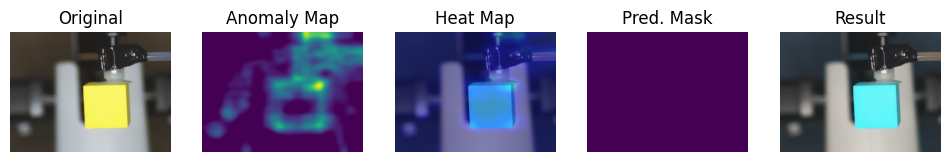

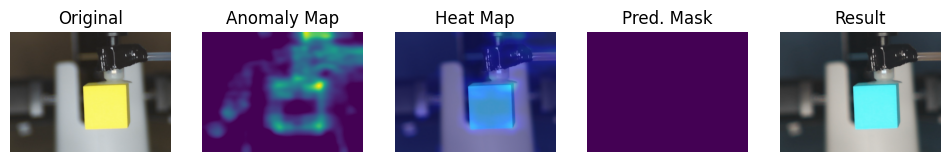

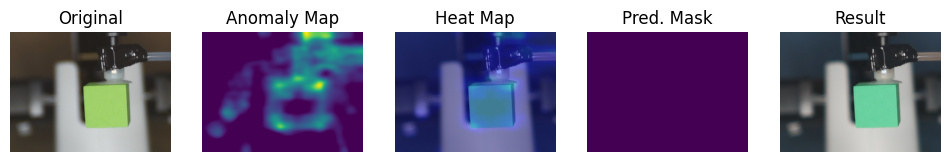

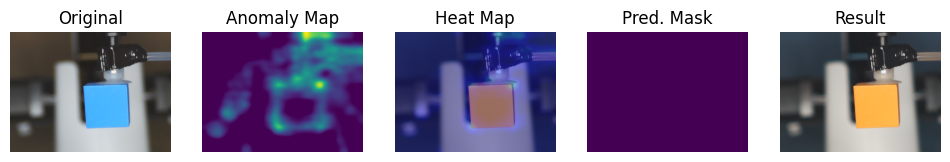

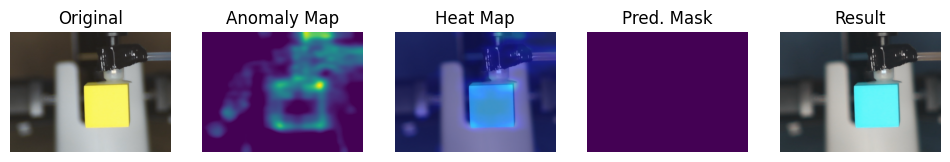

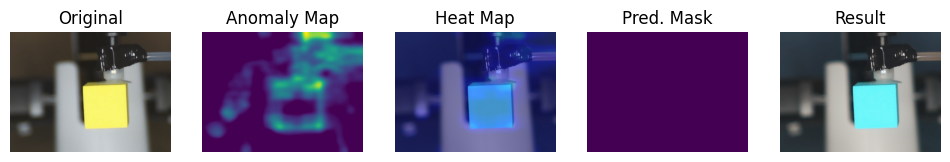

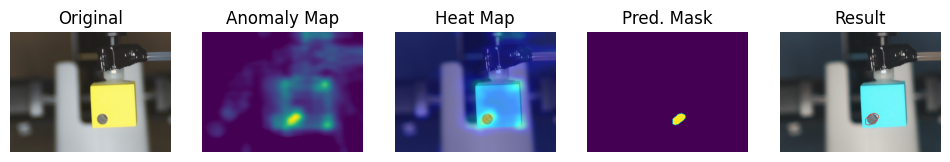

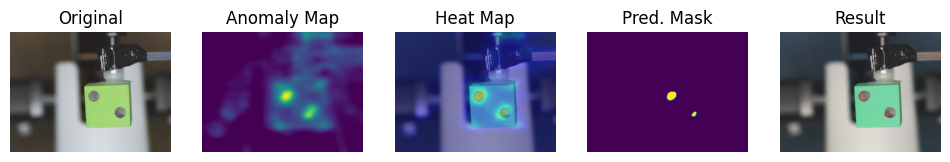

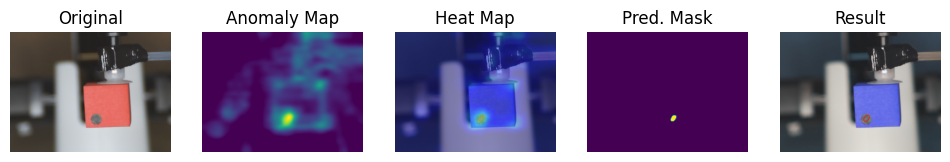

In [6]:
CON_STR = {
    dType.DobotConnect.DobotConnect_NoError:  "DobotConnect_NoError",
    dType.DobotConnect.DobotConnect_NotFound: "DobotConnect_NotFound",
    dType.DobotConnect.DobotConnect_Occupied: "DobotConnect_Occupied"}

#Load Dll and get the CDLL object
api = dType.load()

#Connect Dobot
state = dType.ConnectDobot(api, "", 115200)[0]
print("Connect status:",CON_STR[state])

use_popup = True #True

if (state == dType.DobotConnect.DobotConnect_NoError):

    Calibration__0__Run__1 = None
    Calibration_X = None
    Calibration_Y = None
    Calibration_Z = None
    Place_X = None
    Place_Y = None
    Place_Z = None
    Anomaly_X = None
    Anomaly_Y = None
    Anomaly_Z = None
    j = None
    k = None
    time_start = None
  
    print('[HOME] Restore to home position at first launch, please wait 30 seconds after turnning on the Dobot Magician.')
    print('[BLOCKS] Place them besides the non-motor side of the conveyor belt, the same side where the pick and place arm is.')
    print('[PLACING BLOCKS] Place the blocks by 3×3.')
    print('[CALIBRATION POINT] Looking from the back of Dobot, the top left block is the calibration point.')
    print('[CALIBRATION] Set the first variable to 0 to test the calibration point, then set 1 to start running.')
    print('[DIRECTION] Standing behind Dobot Magician facing its front direction, X is front and back direction, Y is left and right direction. ')
    print('[CONNECTION] Motor of the conveyor belt connects to port Stepper1.')
    
    Calibration__0__Run__1 = 1
    Calibration_X = 221.2288
    Calibration_Y = -117.0036
    Calibration_Z = -42.3512
    Place_X = 23.7489 #42.2995 #
    Place_Y = -264.2602 #-264.6927 #
    Place_Z = 18.0862 #63.65 #
    Anomaly_X = -112 #-84.287 #
    Anomaly_Y = -170 #-170.454 #
    Anomaly_Z = 90 #61.5359 #
    dType.SetEndEffectorParamsEx(api, 59.7, 0, 0, 1)
    j = 0
    k = 0
    dType.SetPTPJointParamsEx(api,400,400,400,400,400,400,400,400,1)
    dType.SetPTPCommonParamsEx(api,100,100,1)
    dType.SetPTPJumpParamsEx(api,40,100,1)
    dType.SetPTPCmdEx(api, 0, Calibration_X,  Calibration_Y,  Calibration_Z, 0, 1)
    dType.SetEndEffectorSuctionCupEx(api, 0, 1)
    STEP_PER_CRICLE = 360.0 / 1.8 * 10.0 * 16.0
    MM_PER_CRICLE = 3.1415926535898 * 36.0
    vel = float(0) * STEP_PER_CRICLE / MM_PER_CRICLE
    dType.SetEMotorEx(api, 1, 0, int(vel), 1)

    if Calibration__0__Run__1:
        

        for count in range(9):
            # initializing and starting multi-threaded webcam input stream 
            cam_stream = CamStream(stream_id=0) # 0 id for main camera
            cam_stream.start()
            
            dType.SetPTPCmdEx(api, 0, (Calibration_X - j),  (Calibration_Y - k),  (Calibration_Z - 10), 0, 1)
            dType.SetEndEffectorSuctionCupEx(api, 1, 1)
            #dType.dSleep(150)
            dType.SetPTPCmdEx(api, 0, (Place_X - 0),  (Place_Y - 0),  (Place_Z + 90), 0, 1)
            
            # adding a delay for simulating video processing time 
            delay = 0.3 # delay value in seconds
            time.sleep(delay)
            ### Capture a frame from the video player - start thread
            frame = cam_stream.read()
            if not(acquisition):
                # Get the inference results.
                ###INFERENCE WITH OPENVINO
                predictions = inferencer.predict(image=frame)
                print(predictions.pred_score)
                if predictions.pred_score > 0.48: #modify the threshold depending of your needs
                    dType.SetPTPCmdEx(api, 0, Anomaly_X,  Anomaly_Y,  Anomaly_Z, 0, 1) ### define point for abnormalities
                else:
                    dType.SetPTPCmdEx(api, 0, Place_X,  Place_Y,  Place_Z, 0, 1)
                #visualize(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                visualize(predictions)

            if acquisition:
                ### create filename to next frame
                filename = filename_fc(acquisition, folder, dataset_path)
                cv2.imwrite(filename, frame)
                dType.SetPTPCmdEx(api, 0, Place_X,  Place_Y,  Place_Z, 0, 1)
                #print("continue in the conveyor belt")

            dType.SetEndEffectorSuctionCupEx(api, 0, 1)
            #dType.dSleep(150)
            j = j + 25
            if j == 75:
                k = k + 25
                j = 0
            dType.SetPTPCmdEx(api, 7, 0,  0,  20, 0, 1)
            time_start = dType.gettime()[0]
            STEP_PER_CRICLE = 360.0 / 1.8 * 10.0 * 16.0
            MM_PER_CRICLE = 3.1415926535898 * 36.0
            vel = float(50) * STEP_PER_CRICLE / MM_PER_CRICLE
            dType.SetEMotorEx(api, 1, 1, int(vel), 1)
            filename = None
            score = 0
            while True:
                if (dType.gettime()[0]) - time_start >= 0.5 : # Time over conveyor belt
                    STEP_PER_CRICLE = 360.0 / 1.8 * 10.0 * 16.0
                    MM_PER_CRICLE = 3.1415926535898 * 36.0
                    vel = float(0) * STEP_PER_CRICLE / MM_PER_CRICLE
                    dType.SetEMotorEx(api, 1, 0, int(vel), 1)
                    break
        dType.SetEndEffectorSuctionCupEx(api, 0, 1)
        dType.SetPTPCmdEx(api, 0, Calibration_X,  Calibration_Y,  Calibration_Z, 0, 1)
        cam_stream.stop() # stop the webcam stream
